### About
### Build a machine learning model that can calculate the time the delivery person takes to deliver the order.

### Import the necessary packages and libraries.

In [ ]:
!pip install imbalanced-learn==0.7.0 -q
!pip install --user pycaret[full] -q
!pip install numba==0.53 -q

In [1]:
import pycaret
from pycaret.regression import *

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
#import klib

import datetime
from scipy.stats import skew, kurtosis
from prettytable import PrettyTable

### Import train and test dataset

In [138]:
train=pd.read_csv("../input/amazonbusinessresearchanalysthiringchallenge/train.csv")
test=pd.read_csv("../input/amazonbusinessresearchanalysthiringchallenge/test.csv")

### Pre-processing function

In [139]:
def pre_process(df,data=""):
    #tidy column names
    df=df.rename(columns={col:re.sub("\s","_",col.lower())   for col in df.columns.values})
    
    #create missing value indicator columns
    for col in df.columns[df.isnull().any()].values:
        df[f"{col}_isnull"]=(df[col].isnull()).astype('int')
    
    #fill the missing value for the column delivery_person_age
    df['delivery_person_age']=df['delivery_person_age'].fillna(df.groupby('delivery_person_id')['delivery_person_age'].transform('mean'))
    
    # #fill the missing value for the column delivery_person_ratings
    df['delivery_person_ratings']=df['delivery_person_ratings'].fillna(df.groupby('delivery_person_id')['delivery_person_ratings'].transform('mean'))
    
    #time correction function
    def time_correction(t): 
        if re.fullmatch("(\d+:60)",t):
            time=re.findall("(\d+):60",t)[0]
            time=int(time)+1
            return f"{time}:00"
        elif re.fullmatch("(24:\d{,2})",t):
            return f"23:59"
        else:
            return t
    #apply the time correction to time_orderd column    
    df['time_orderd']=df['time_orderd'].apply(lambda x:time_correction(str(x)))
    
    #replace the 24:00 format
    df['time_orderd']=df['time_orderd'].str.replace("(24:00)","23:59")
    
    #replac nan as NA
    df['time_orderd']=df['time_orderd'].apply(lambda x:pd.NA if re.findall('(nan)',x) else x)
    
    #apply the time correction to time_order_picked column
    df['time_order_picked']=df['time_order_picked'].apply(lambda x:time_correction(x))
    
    #replace the 24:00 format
    df['time_order_picked']=df['time_order_picked'].str.replace("(24:00)","23:59")
    
    #convert order_date and time_orderd to to datetime format
    df["order_date_time"]=pd.to_datetime((df["order_date"].astype('str') +" "+ df['time_orderd'].astype('str')),format="%d-%m-%Y  %H:%M",errors='coerce')
    
    #convert order_date and time_order_picked to to datetime format
    df["picked_date_time"]=pd.to_datetime((df["order_date"].astype('str') +" "+ df['time_order_picked'].astype('str')),format="%d-%m-%Y  %H:%M",errors='coerce')
    
    #convert time to float
    df['time_order_picked_new']=df['picked_date_time'].dt.strftime('%H:%m').str.replace(":",".").astype('float')
    
    #difference between order time and picked time
    df['diff_order_picked']=(df["picked_date_time"]-df["order_date_time"]).dt.total_seconds() / 60
    
    #groupby  diff_order_picked mean value
    df['median_diff_order_picked']=df.groupby(['delivery_person_id','type_of_order'])['diff_order_picked'].transform('median')
    
    #fill missing value by column type_of_order
    df['median_diff_order_picked']=df.groupby(['type_of_order'])['diff_order_picked'].transform('median')
    
    #fill missing value by subtraction median_diff_order_picked from picked_date_time
    df['time_orderd']=df['time_orderd'].fillna((df["picked_date_time"]-pd.to_timedelta(df['median_diff_order_picked'],unit='m')).dt.strftime("%H:%M"))
   
    #after filling NA values - convert order_date and time_orderd to datetime format
    df["order_date_time"]=pd.to_datetime((df["order_date"] +" "+ df['time_orderd'].astype('str')),format="%d-%m-%Y  %H:%M",errors='coerce')
    
    #convert order time to float
    df['time_orderd_new']=df['order_date_time'].dt.strftime('%H:%m').str.replace(":",".").astype('float')
    
    #difference between order time and picked time 
    df['diff_order_picked']=(df["picked_date_time"]-df["order_date_time"]).dt.total_seconds() / 60
    
    #extract loc info from person id
    df['delivery_person_loc']=df['delivery_person_id'].str.extract("([A-Z]+)R.+")
    
    #correct the delivery_person_id
    df['delivery_person_id']=df['delivery_person_id'].str.replace("(AGRRES010)","AGRRES01")
    
    #fill the missing by mode
    for col in ['weather_conditions','road_traffic_density','multiple_deliveries','festival','city']:
        df[col]=df[col].fillna(df[col].mode()[0])
    
    #function replace negative geocodes
    def positive_geocode(geo):
        if geo < 0:
            return geo*-1
        else:
            return geo
    
    #apply positive_geocode to geocode columns
    for col in ['restaurant_latitude','restaurant_longitude','delivery_location_latitude','delivery_location_longitude']:
        df[col]=df[col].apply(lambda x:positive_geocode(x))
    
    #function to find a distance between two geocodes
    def haversine_vectorize(lon1, lat1, lon2, lat2):

        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        newlon = lon2 - lon1
        newlat = lat2 - lat1

        haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

        dist = 2 * np.arcsin(np.sqrt(haver_formula ))
        km = 6367 * dist #6367 for distance in KM for miles use 3958
        return km
    
    
    #create a distance column by using haversine_vectorize function
    df['restaurant_delivery_distance']=haversine_vectorize(df['restaurant_latitude'],df['restaurant_longitude'],df['delivery_location_latitude'],df['delivery_location_longitude'])
    
    #datetime feature engineering
    def date_pre_process(df):
        df['date_time']=pd.to_datetime((df["order_date"] +" "+ df['time_order_picked'].astype('str')),format="%d-%m-%Y  %H:%M") #convert to date-time format
        #df['date_time']=pd.to_datetime(df["order_date"])
        df['day']=df['date_time'].dt.day #extract day from the date
        df['day_label']=df['date_time'].dt.day_name() #extract the day name from the date
        df['day_number']=df['date_time'].dt.dayofweek #extract the day number from the date
        df['month_number']=df['date_time'].dt.month #extract month number from the date
        df['month_label']=df['date_time'].dt.strftime('%b') #extract the month name from the date
        df['year_quarter']=df['date_time'].dt.quarter #extract the quarter of the year
        df['week_of_year']=df['date_time'].dt.week #extract week of the year from date
        df['year']= df['date_time'].dt.year #extract year
        df['dayofmonth'] = df['date_time'].dt.daysinmonth #extract the day of the month
        df['dayofyear'] = df['date_time'].dt.day_of_year #extract day of the year
        df['weekday']=df['date_time'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype('int') #create weekday column
        df['weekend']=df['date_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype('int') #create weekend column
        df['month_start']=df['date_time'].dt.is_month_start.astype('int') #create month start
        df['month_end']=df['date_time'].dt.is_month_end.astype('int') #create month end
        df['quarter_start']=df['date_time'].dt.is_quarter_start.astype('int') #create quarter start
        df['quarter_end']=df['date_time'].dt.is_quarter_end.astype('int') #create quarter end
        df['year_start']=df['date_time'].dt.is_year_start.astype('int') #create year start
        df['year_end']=df['date_time'].dt.is_year_end.astype('int') #create year end
        df['hour']=df['date_time'].dt.hour

          #function to convert month to seasons
        def month2seasons(x):
            season=""
            if x in [1, 2]:
                season = 'winter'
            elif x in [3, 4, 5]:
                season = 'summer'
            elif x in [6,7,8,9]:
                season = 'monsoon'
            elif x in [10,11,12]:
                season = 'post-monsoon'
            return season


        df['seasons']=df['month_number'].apply(month2seasons)

        def hours2timing(x):
            if x in range(20,23):
                timing = 'Night'
            elif x in range(5,12):
                timing = 'Morning'
            elif x in range(12, 16):
                timing = 'Afternoon'
            elif x in range(16, 20):
                timing = 'Evening'
            elif x in [23,0,1,2,3,4]:
                timing = 'Midnight'    
            else:
                timing = 'X'
            return timing



        df['timings']=df['hour'].apply(hours2timing) 

        return df
    
    #apply date_pre_process to dataframe
    df=date_pre_process(df)
    """
    
    #categorical columns list

    grpcol=['delivery_person_id']

    #numerical columns list
    numcols=['delivery_person_age','delivery_person_ratings']
                   

    
    #group by numerical summary of each numerical column
    def feature_eng(df):
        for valcol in numcols:
            df1=(df.groupby(grpcol)[valcol].agg({'min','median','mean','max'}).reset_index())
            df1=(df1.rename(columns={c:valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                match("(min|median|mean|max|)")]}))
            df=pd.merge(df,df1,on=grpcol,how='left')
        return df  


    df=feature_eng(df)
    """
    if data is 'train':
        df=df.drop(columns=['file_name', 'id','order_date', 'time_orderd',
                   'time_order_picked' ,'order_date_time', 'picked_date_time','date_time',
                    'day_label','month_label','hour'],axis=1)
    else:
        df=df.drop(columns=['file_name','order_date', 'time_orderd',
                   'time_order_picked' ,'order_date_time', 'picked_date_time','date_time',
                    'day_label','month_label','hour'],axis=1)
        

    return df
    
    
    
    
    

    

### Apply the pre-processing steps to train dataset

In [140]:
train=pre_process(train,data='train')

In [159]:
for i,j in enumerate(train.columns.values):
    print(f"{i}_{j}")

0_delivery_person_id
1_delivery_person_age
2_delivery_person_ratings
3_restaurant_latitude
4_restaurant_longitude
5_delivery_location_latitude
6_delivery_location_longitude
7_weather_conditions
8_road_traffic_density
9_vehicle_condition
10_type_of_order
11_type_of_vehicle
12_multiple_deliveries
13_festival
14_city
15_time_taken_(min)
16_delivery_person_age_isnull
17_delivery_person_ratings_isnull
18_time_orderd_isnull
19_weather_conditions_isnull
20_road_traffic_density_isnull
21_multiple_deliveries_isnull
22_festival_isnull
23_city_isnull
24_time_order_picked_new
25_diff_order_picked
26_median_diff_order_picked
27_time_orderd_new
28_delivery_person_loc
29_restaurant_delivery_distance
30_day
31_day_number
32_month_number
33_year_quarter
34_week_of_year
35_year
36_dayofmonth
37_dayofyear
38_weekday
39_weekend
40_month_start
41_month_end
42_quarter_start
43_quarter_end
44_year_start
45_year_end
46_seasons
47_timings


### Split predictor(X) and response(y) variable

In [147]:
X=train.iloc[:,np.r_[0:15,16:48]]
y=train['time_taken_(min)']

### Create a new dataframe with concatenate the selected predictor and response variable.

In [149]:
train1=pd.concat([X,y],axis=1)

### Setup model to train

In [150]:
reg_pycaret = setup(data = train1,
                    data_split_shuffle=True,
                    fold_strategy="kfold",
                       #fold_groups='',
                    fold_shuffle=True,
                    #normalize=True,
                    #remove_outliers=True,
                    fold=5,
                    target = 'time_taken_(min)', session_id=112,
                    
                    use_gpu =True,
                    silent=True
                    ) 
set_config('seed', 123)

,Description,Value
0,session_id,112
1,Target,time_taken_(min)
2,Original Data,"(45593, 48)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,33
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(31915, 1411)"


### Compare multiple regression models and evalute by using R2

In [151]:
top3 = compare_models(sort = 'R2',n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,3.1645,15.8566,3.9820,0.8199,0.1633,0.1378,2.7180
catboost,CatBoost Regressor,3.1909,16.0788,4.0098,0.8174,0.1642,0.1389,11.8940
rf,Random Forest Regressor,3.1938,16.3634,4.0451,0.8141,0.1664,0.1389,53.6480
et,Extra Trees Regressor,3.2054,16.8154,4.1006,0.8090,0.1675,0.1386,237.5180
xgboost,Extreme Gradient Boosting,3.2693,16.8733,4.1076,0.8084,0.1686,0.1425,3.9860
gbr,Gradient Boosting Regressor,3.6651,21.1780,4.6018,0.7594,0.1902,0.1626,46.9760
dt,Decision Tree Regressor,4.1180,29.6372,5.4440,0.6634,0.2231,0.1766,3.1760
br,Bayesian Ridge,4.7238,34.9382,5.9108,0.6031,0.2409,0.2083,17.0120
lar,Least Angle Regression,4.7248,34.9697,5.9134,0.6028,0.2406,0.2086,2.0340
omp,Orthogonal Matching Pursuit,4.7482,35.3319,5.9440,0.5986,0.2425,0.2093,1.0840


### Blend the top 3 models.

In [152]:
blender = blend_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.1213,15.1358,3.8905,0.8247,0.1615,0.1369
1,3.1275,15.3078,3.9125,0.8260,0.1596,0.1347
2,3.1043,15.4725,3.9335,0.8235,0.1622,0.1362
3,3.1354,15.5502,3.9434,0.8286,0.1606,0.1355
4,3.1051,15.3104,3.9129,0.8252,0.1620,0.1364
Mean,3.1187,15.3554,3.9185,0.8256,0.1612,0.1359
Std,0.0123,0.1443,0.0184,0.0017,0.0009,0.0008


### Finalize the blender mode

In [153]:
final = finalize_model(blender)

In [161]:
from sklearn import set_config
set_config(display="diagram")

In [162]:
final

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0, device='gpu',
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=112,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent='warn', subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_freq=0)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fca89936710>),
                            ('rf', RandomForestRegressor())],
                n_jobs=1, verbose=False, weights=None)

### Model Residual Plot

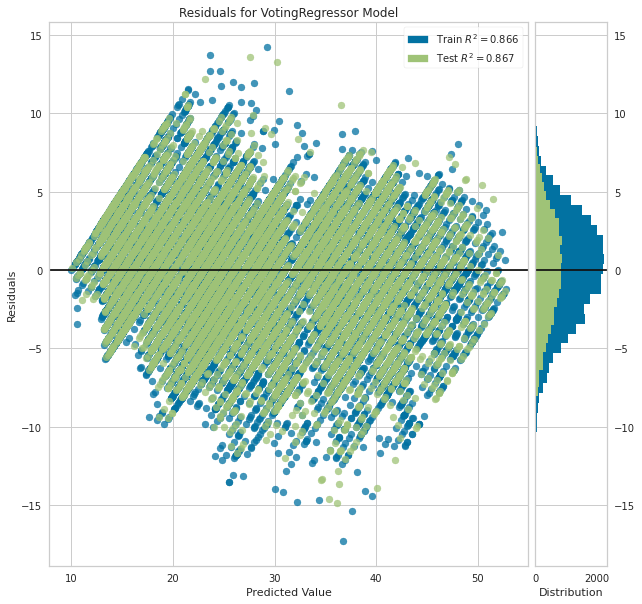

In [163]:
plt.figure(figsize = (10,10))
plot_model(final, plot = 'residuals')

### Error plot

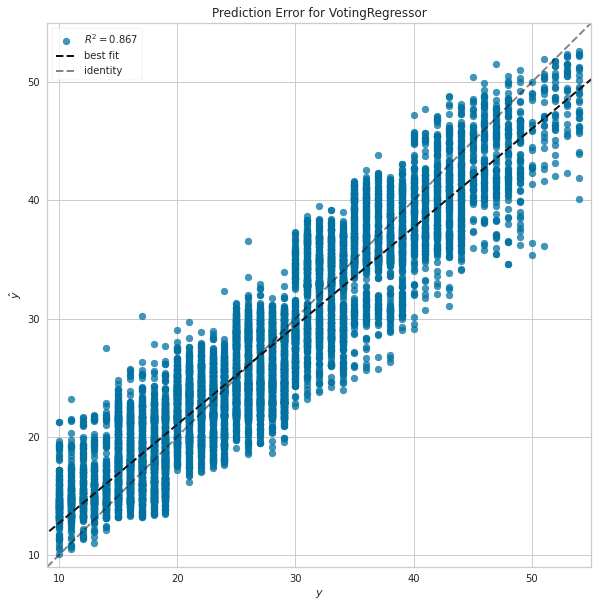

In [164]:
plt.figure(figsize = (10,10))
plot_model(final, plot = 'error')

### Lightgbm model feature importance plot

<Figure size 720x720 with 0 Axes>

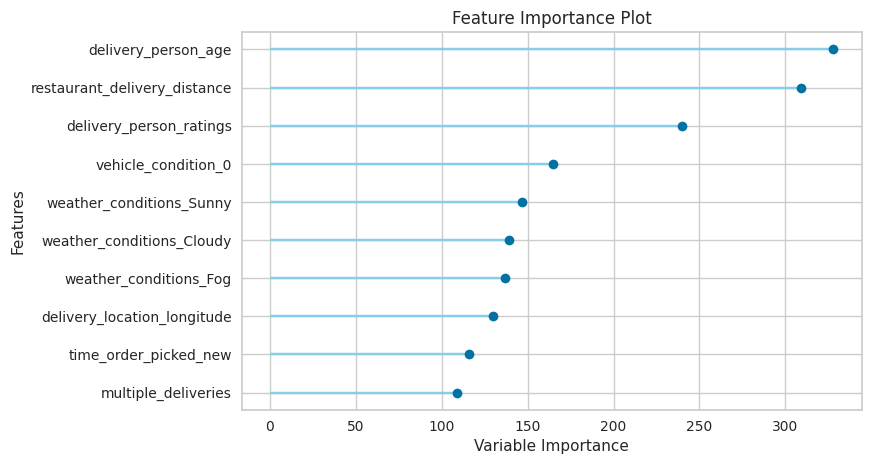

In [165]:
plt.figure(figsize = (10,10));
plot_model(final.named_estimators_[list(final.named_estimators)[0]], plot = 'feature');

### SHAP feature importance plot

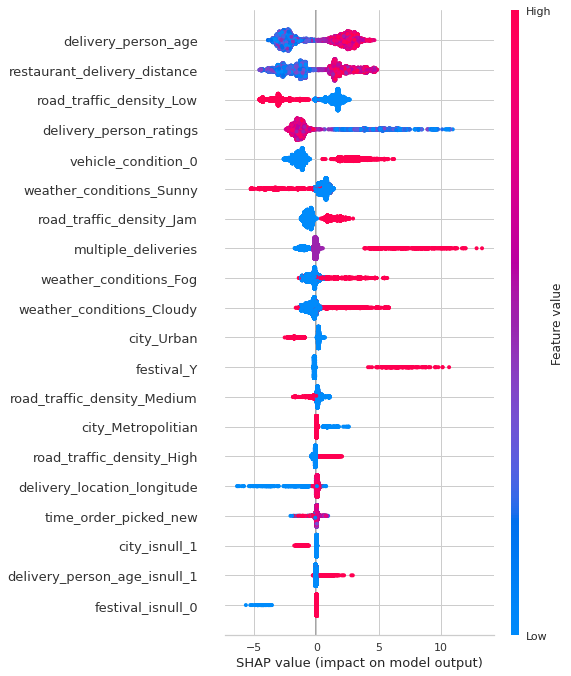

In [166]:
interpret_model(final.named_estimators_[list(final.named_estimators)[0]])

### Apply the pre-process steps to test dataset

In [142]:
test=pre_process(test)

### Predict the test data by using finalized blended model

In [155]:
test['Time_taken (min)']=(predict_model(final, data=test.loc[:,X.columns])['Label'])

### Create a result dataframe

In [156]:
res=pd.DataFrame({'ID':test['id'],'Time_taken (min)':test['Time_taken (min)']})

In [158]:
res['Time_taken (min)'].describe()

count    11399.000000
mean        26.179634
std          8.396003
min         10.279592
25%         19.923404
50%         24.360630
75%         31.608906
max         53.227984
Name: Time_taken (min), dtype: float64

### Write the result dataframe to csv

In [157]:
res.to_csv("pycaret_blend_final.csv",index=False)

### Time_taken_(min) distribution of train and test data  

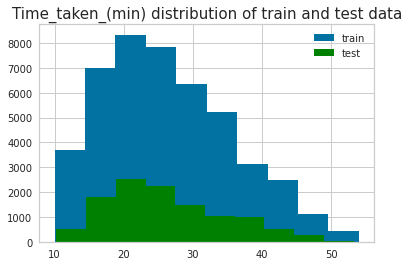

In [176]:
plt.hist(train['time_taken_(min)'],label='train');
plt.hist(res['Time_taken (min)'],color='Green',label='test');
plt.title("Time_taken_(min) distribution of train and test data",fontsize=15);
plt.legend();